# **10. Image Segmentation**


Image segmentation is one of the most important intermediate topics in computer vision.
While image classification assigns a single label to an entire image, segmentation works at a much finer level. Instead of asking “What is in this picture?”, segmentation asks:

“Which pixels belong to which object or region?”

This means segmentation divides an image into meaningful parts, such as separating a foreground object from its background, splitting different objects apart, or identifying regions like sky, grass, or roads.

Segmentation is widely used in many real-world applications. In medical imaging, it can outline organs or detect tumors. In autonomous driving, it helps identify roads, vehicles, and pedestrians. In photo editing, segmentation is the foundation of background removal and object cutouts. Robotics also relies on segmentation to locate objects for grasping and interaction.

In this notebook-style lecture, we explore three classical segmentation approaches:

* K-means color segmentation
* Watershed segmentation
* GrabCut foreground extraction

##### **Types of Image Segmentation**

Before applying specific algorithms, it is useful to recognize that segmentation problems can be defined at different levels of detail.

One major category is semantic segmentation. In semantic segmentation, every pixel in an image is assigned a class label such as road, tree, person, or sky. All pixels that belong to the same category are treated as one unified region. For example, even if a road appears in multiple areas of the image, semantic segmentation labels all those pixels simply as “road,” without separating them into different road segments. This is especially useful when understanding the overall scene layout is more important than identifying individual objects.

A more advanced form is instance segmentation, which adds another layer of information. Instead of grouping all objects of the same class together, instance segmentation separates individual object occurrences. For example, if several cars appear in an image, the algorithm will label each one as a distinct instance rather than one combined “car” region. This is essential in tasks where distinguishing between multiple similar objects matters, such as detecting pedestrians or vehicles in traffic environments.

Finally, panoptic segmentation combines both approaches into a single complete representation. Each pixel is labeled with a class category, and object pixels additionally receive an instance identifier. Background regions such as road, sky, or grass are handled semantically, while countable objects like cars, people, or animals are separated individually. Panoptic segmentation provides a holistic understanding of a scene and is widely considered one of the most comprehensive segmentation formulations.

## **10.1. K-Means Color Segmentation**

The first approach is K-means segmentation, which is based purely on pixel color information. K-means is an unsupervised clustering algorithm. When applied to images, we treat each pixel as a point in RGB space. The algorithm then groups pixels into K clusters based on similarity.

Each cluster is represented by its average color, so the segmented image becomes a simplified version containing only a small number of dominant colors.

This method does not truly “understand” objects, but it is useful for reducing complexity and separating regions that have distinct color differences.

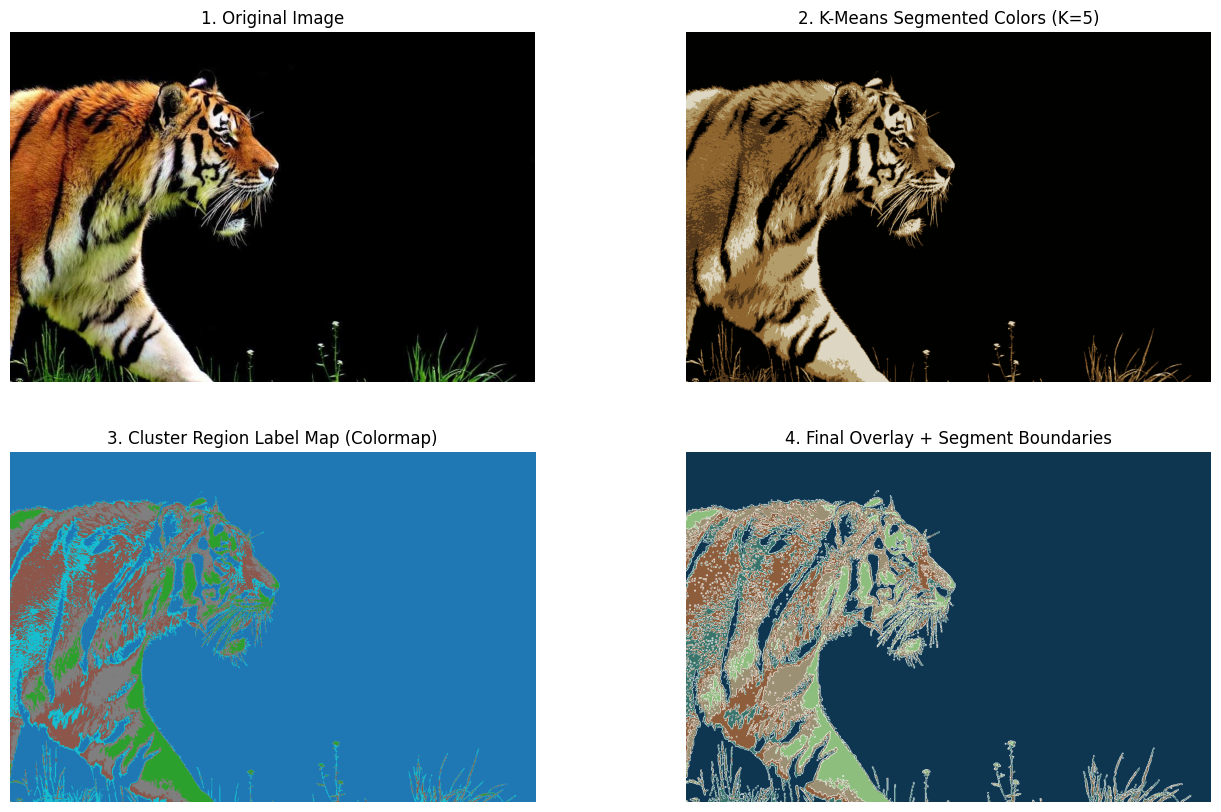

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# -----------------------------
# Load the tiger image
# -----------------------------
img = cv2.imread("tiger.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# -----------------------------
# Step 1: Reshape pixels for clustering
# -----------------------------
# Convert image into a 2D array: (num_pixels × 3)
pixels = img_rgb.reshape((-1, 3))
pixels = np.float32(pixels)

# -----------------------------
# Step 2: Apply K-Means clustering
# -----------------------------
K = 5  # number of color segments

criteria = (
    cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
    50,
    0.2
)

_, labels, centers = cv2.kmeans(
    pixels, K, None,
    criteria, 10,
    cv2.KMEANS_RANDOM_CENTERS
)

# Convert cluster centers back to RGB colors
centers = np.uint8(centers)

# -----------------------------
# Step 3: Reconstruct segmented image
# -----------------------------
segmented_pixels = centers[labels.flatten()]
segmented_img = segmented_pixels.reshape(img_rgb.shape)

# -----------------------------
# Step 4: Create label map (region index per pixel)
# -----------------------------
label_map = labels.reshape(img_rgb.shape[:2])

# Normalize labels for colormap display
norm_labels = label_map / (K - 1)

# Apply a colormap (region visualization)
colored_mask = cm.tab10(norm_labels)
colored_mask = (colored_mask[:, :, :3] * 255).astype(np.uint8)

# -----------------------------
# Step 5: Overlay region colors on segmented image
# -----------------------------
alpha = 0.45  # transparency level

overlay_result = cv2.addWeighted(
    segmented_img, 1 - alpha,
    colored_mask, alpha,
    0
)

# -----------------------------
# Step 6: Draw segment boundaries
# -----------------------------
edges = cv2.Canny(label_map.astype(np.uint8), 0, 1)

# Highlight boundaries in white
overlay_result[edges != 0] = [255, 255, 255]

# -----------------------------
# Display results (4 images like GrabCut/Watershed)
# -----------------------------
plt.figure(figsize=(16,10))

plt.subplot(2,2,1)
plt.title("1. Original Image")
plt.imshow(img_rgb)
plt.axis("off")

plt.subplot(2,2,2)
plt.title(f"2. K-Means Segmented Colors (K={K})")
plt.imshow(segmented_img)
plt.axis("off")

plt.subplot(2,2,3)
plt.title("3. Cluster Region Label Map (Colormap)")
plt.imshow(colored_mask)
plt.axis("off")

plt.subplot(2,2,4)
plt.title("4. Final Overlay + Segment Boundaries")
plt.imshow(overlay_result)
plt.axis("off")

plt.show()


## **10.2. Watershed Segmentation**

The second technique is watershed segmentation, which is inspired by geography. The image is interpreted as a topographic surface, where pixel intensity corresponds to height.

Dark pixels act like valleys and bright pixels like peaks. If we imagine flooding this surface with water, different basins fill up. When two flooded basins meet, a boundary forms. These boundaries define the segmentation result.

Watershed is especially powerful when separating objects that touch each other, but it requires preprocessing steps such as thresholding and marker generation.

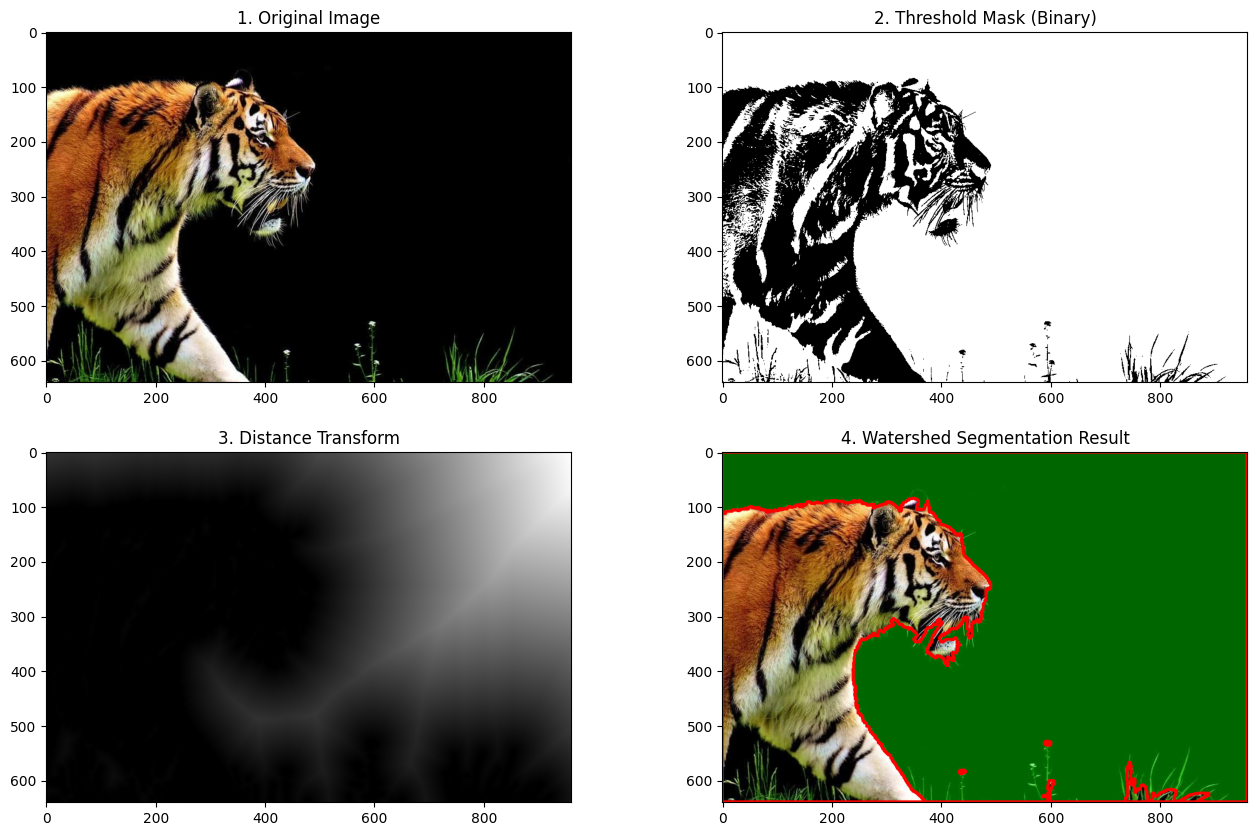

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Load image
# -----------------------------
img = cv2.imread("tiger.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# -----------------------------
# Step 1: Convert to grayscale
# -----------------------------
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# -----------------------------
# Step 2: Otsu Thresholding
# -----------------------------
_, thresh = cv2.threshold(
    gray, 0, 255,
    cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
)

# -----------------------------
# Step 3: Noise removal (Morphology)
# -----------------------------
kernel = np.ones((3, 3), np.uint8)
clean = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# -----------------------------
# Step 4: Sure background region
# -----------------------------
sure_bg = cv2.dilate(clean, kernel, iterations=3)

# -----------------------------
# Step 5: Distance transform (foreground detection)
# -----------------------------
dist_transform = cv2.distanceTransform(clean, cv2.DIST_L2, 5)

_, sure_fg = cv2.threshold(
    dist_transform, 0.7 * dist_transform.max(), 255, 0
)

sure_fg = np.uint8(sure_fg)

# -----------------------------
# Step 6: Unknown region
# -----------------------------
unknown = cv2.subtract(sure_bg, sure_fg)

# -----------------------------
# Step 7: Marker labeling
# -----------------------------
_, markers = cv2.connectedComponents(sure_fg)

markers = markers + 1
markers[unknown == 255] = 0

# -----------------------------
# Step 8: Apply Watershed
# -----------------------------
markers = cv2.watershed(img, markers)

# -----------------------------
# Step 9: Foreground overlay visualization
# -----------------------------
foreground_mask = markers > 1

overlay = img_rgb.copy()
overlay[foreground_mask] = [0, 255, 0]  # green foreground

alpha = 0.4
segmented_view = cv2.addWeighted(
    overlay, alpha,
    img_rgb, 1 - alpha,
    0
)

# -----------------------------
# Step 10: Draw watershed boundaries
# -----------------------------
boundary_mask = markers == -1

boundary_mask = cv2.dilate(
    boundary_mask.astype(np.uint8),
    np.ones((3, 3), np.uint8),
    iterations=2
)

segmented_view[boundary_mask == 1] = [255, 0, 0]  # red boundary

# -----------------------------
# Display results (4 images)
# -----------------------------
plt.figure(figsize=(16,10))

plt.subplot(2,2,1)
plt.title("1. Original Image")
plt.imshow(img_rgb)

plt.subplot(2,2,2)
plt.title("2. Threshold Mask (Binary)")
plt.imshow(thresh, cmap="gray")

plt.subplot(2,2,3)
plt.title("3. Distance Transform")
plt.imshow(dist_transform, cmap="gray")

plt.subplot(2,2,4)
plt.title("4. Watershed Segmentation Result")
plt.imshow(segmented_view)

plt.show()


## **10.3. GrabCut Foreground Extraction**

The third method, GrabCut, is designed specifically for extracting foreground objects. Unlike K-means, which only considers color clusters, GrabCut uses an iterative graph-based optimization technique.

The user provides an initial rectangle around the object of interest, and the algorithm refines the segmentation by modeling foreground and background regions over multiple iterations.

GrabCut is widely used in interactive photo editing because it produces high-quality object cutouts with minimal manual effort.

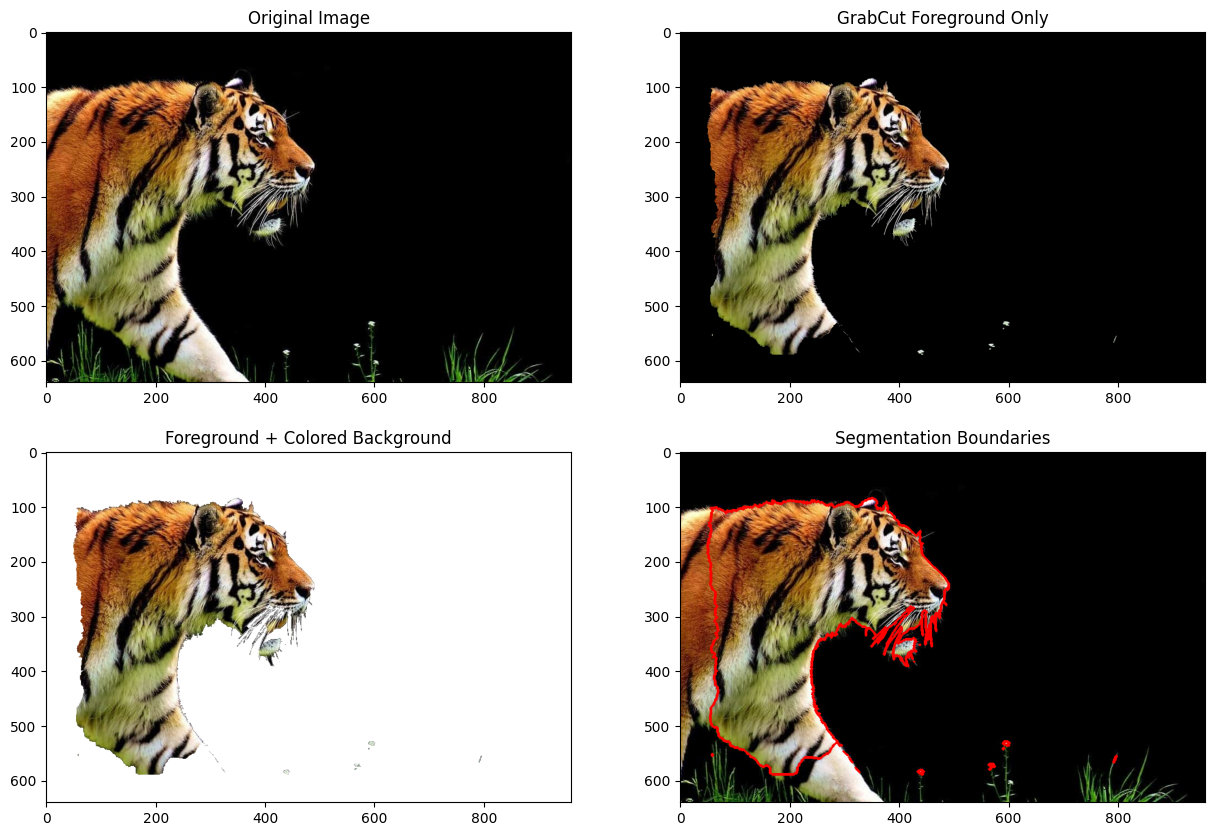

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Load image
# -----------------------------
img = cv2.imread("tiger.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# -----------------------------
# Step 1: Initialize mask and models
# -----------------------------
mask = np.zeros(img.shape[:2], np.uint8)

bg_model = np.zeros((1, 65), np.float64)
fg_model = np.zeros((1, 65), np.float64)

# -----------------------------
# Step 2: Define rectangle around tiger
# -----------------------------
x, y, w, h = 50, 50, img.shape[1] - 100, img.shape[0] - 100
rect = (x, y, w, h)

# -----------------------------
# Step 3: Apply GrabCut
# -----------------------------
cv2.grabCut(
    img, mask, rect,
    bg_model, fg_model,
    5, cv2.GC_INIT_WITH_RECT
)

# -----------------------------
# Step 4: Convert mask to binary foreground/background
# -----------------------------
binary_mask = np.where(
    (mask == cv2.GC_BGD) | (mask == cv2.GC_PR_BGD),
    0, 1
).astype("uint8")

# -----------------------------
# Step 5: Foreground extraction
# -----------------------------
foreground = img_rgb * binary_mask[:, :, np.newaxis]

# -----------------------------
# Step 6: Full coloring background
# -----------------------------
# Create a solid background (white)
colored_bg = np.ones_like(img_rgb) * 255

# Combine foreground + colored background
full_colored_result = (
    foreground + colored_bg * (1 - binary_mask[:, :, np.newaxis])
)

# -----------------------------
# Step 7: Draw boundaries around object
# -----------------------------
# Find contours of the segmented foreground
contours, _ = cv2.findContours(
    binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

# Copy image for boundary visualization
boundary_result = img_rgb.copy()

# Draw contour boundaries in red
cv2.drawContours(boundary_result, contours, -1, (255, 0, 0), 3)

# -----------------------------
# Display results
# -----------------------------
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.title("Original Image")
plt.imshow(img_rgb)

plt.subplot(2,2,2)
plt.title("GrabCut Foreground Only")
plt.imshow(foreground)

plt.subplot(2,2,3)
plt.title("Foreground + Colored Background")
plt.imshow(full_colored_result.astype("uint8"))

plt.subplot(2,2,4)
plt.title("Segmentation Boundaries")
plt.imshow(boundary_result)

plt.show()
